In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

/tmp/ipykernel_2025495/638502812.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
660,Lymphocyte,9.802979e-09,3.196895e-09,0.001083,Chiou.Nature.2021.Type_1_diabetes_,2.965274
661,Microglia-3,5.052252e-09,2.085195e-09,0.007698,Chiou.Nature.2021.Type_1_diabetes_,2.113609
662,Microglia-2,3.898444e-09,1.774327e-09,0.014005,Chiou.Nature.2021.Type_1_diabetes_,1.853709
663,Microglia-1,2.015061e-09,1.582615e-09,0.101465,Chiou.Nature.2021.Type_1_diabetes_,0.993684
664,Endo,1.119049e-09,1.528991e-09,0.232119,Chiou.Nature.2021.Type_1_diabetes_,0.634290


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

6301    3.542999e-08
6300    3.542999e-08
2460    7.596221e-08
2461    1.422445e-07
5220    2.254122e-07
            ...     
2985    9.993469e-01
2984    9.993469e-01
2992    9.993469e-01
6479    9.993469e-01
2999    9.995586e-01
Name: FDR_BH_corrected, Length: 1140, dtype: float64


In [9]:
print(adj_pval.sort_values())

6301    3.542999e-08
6300    4.503309e-08
2460    7.596221e-08
2461    1.422445e-07
5220    2.254122e-07
            ...     
2987    1.004025e+00
1018    1.004278e+00
1799    1.004302e+00
2986    1.004343e+00
2985    1.004505e+00
Name: adj_pval, Length: 1140, dtype: float64


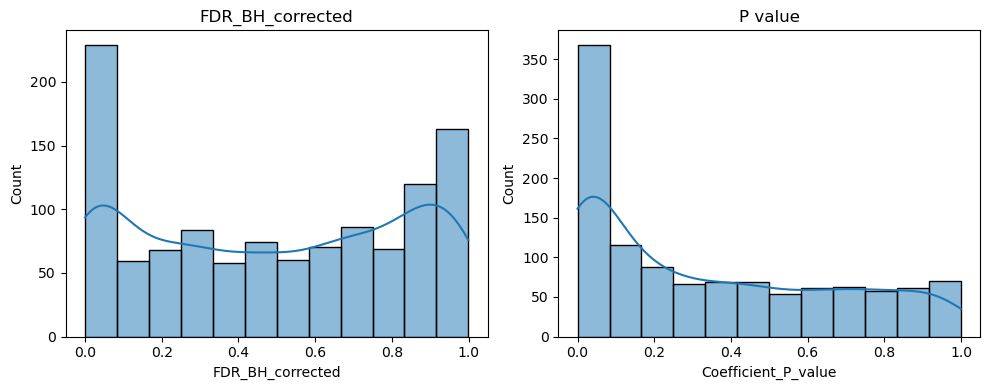

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,2.190354,0.056450,0.076731,0.885502,0.243539,0.784417,0.002058,0.742305,3.718518,6.789038,0.098206,5.883819,0.410245,7.198381,0.077921,5.880731,0.429962,2.400906,0.644567
AMY-SLEA-BNST_GABA,0.208865,0.334406,0.123215,1.530218,0.681987,0.612026,0.033047,0.803089,3.457479,2.053010,1.738616,2.735033,0.825038,3.714389,0.281343,3.375620,0.051988,1.920881,0.072798
Astrocyte-1,0.150860,0.041978,0.159358,0.183489,0.408987,0.348100,0.131881,0.100734,0.749627,1.518950,0.528999,0.482228,0.414407,1.551923,0.098772,1.183288,0.414855,0.790823,0.146807
Astrocyte-2,0.057414,0.006987,0.126486,0.153248,0.047067,0.518545,0.310969,0.188749,1.097376,1.603990,0.536235,0.788544,0.216887,1.816522,0.254517,0.825699,0.253742,0.268711,0.146869
Astrocyte-3,0.044704,0.036385,0.045567,0.298489,0.477166,1.253385,0.486428,0.737213,0.953350,2.425056,1.088782,1.307425,0.320419,2.058646,0.153428,0.805134,0.422253,0.622483,0.160486


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.042026,0.965330,0.943114,0.334965,0.791825,0.388545,0.999347,0.414353,0.002717,0.000006,0.919574,0.000036,0.650514,0.000003,0.942628,0.000036,0.634112,0.028130,0.475050
AMY-SLEA-BNST_GABA,0.824278,0.706608,0.898794,0.129334,0.448190,0.489436,0.980420,0.378475,0.004230,0.053671,0.087440,0.015205,0.366787,0.002717,0.754979,0.004849,0.968119,0.067380,0.946090
Astrocyte-1,0.878922,0.974545,0.867835,0.843025,0.650874,0.694448,0.893838,0.919068,0.410725,0.132225,0.554628,0.591429,0.645638,0.123983,0.919574,0.223137,0.645638,0.384450,0.881548
Astrocyte-2,0.965052,0.999347,0.896985,0.875459,0.970216,0.563507,0.725168,0.840900,0.253766,0.113042,0.549077,0.385670,0.814910,0.080005,0.781326,0.366787,0.781757,0.766587,0.881548
Astrocyte-3,0.970333,0.977968,0.970216,0.736948,0.595549,0.198160,0.586661,0.417939,0.302929,0.027216,0.255283,0.185785,0.716310,0.053262,0.875459,0.377777,0.640674,0.488160,0.866673


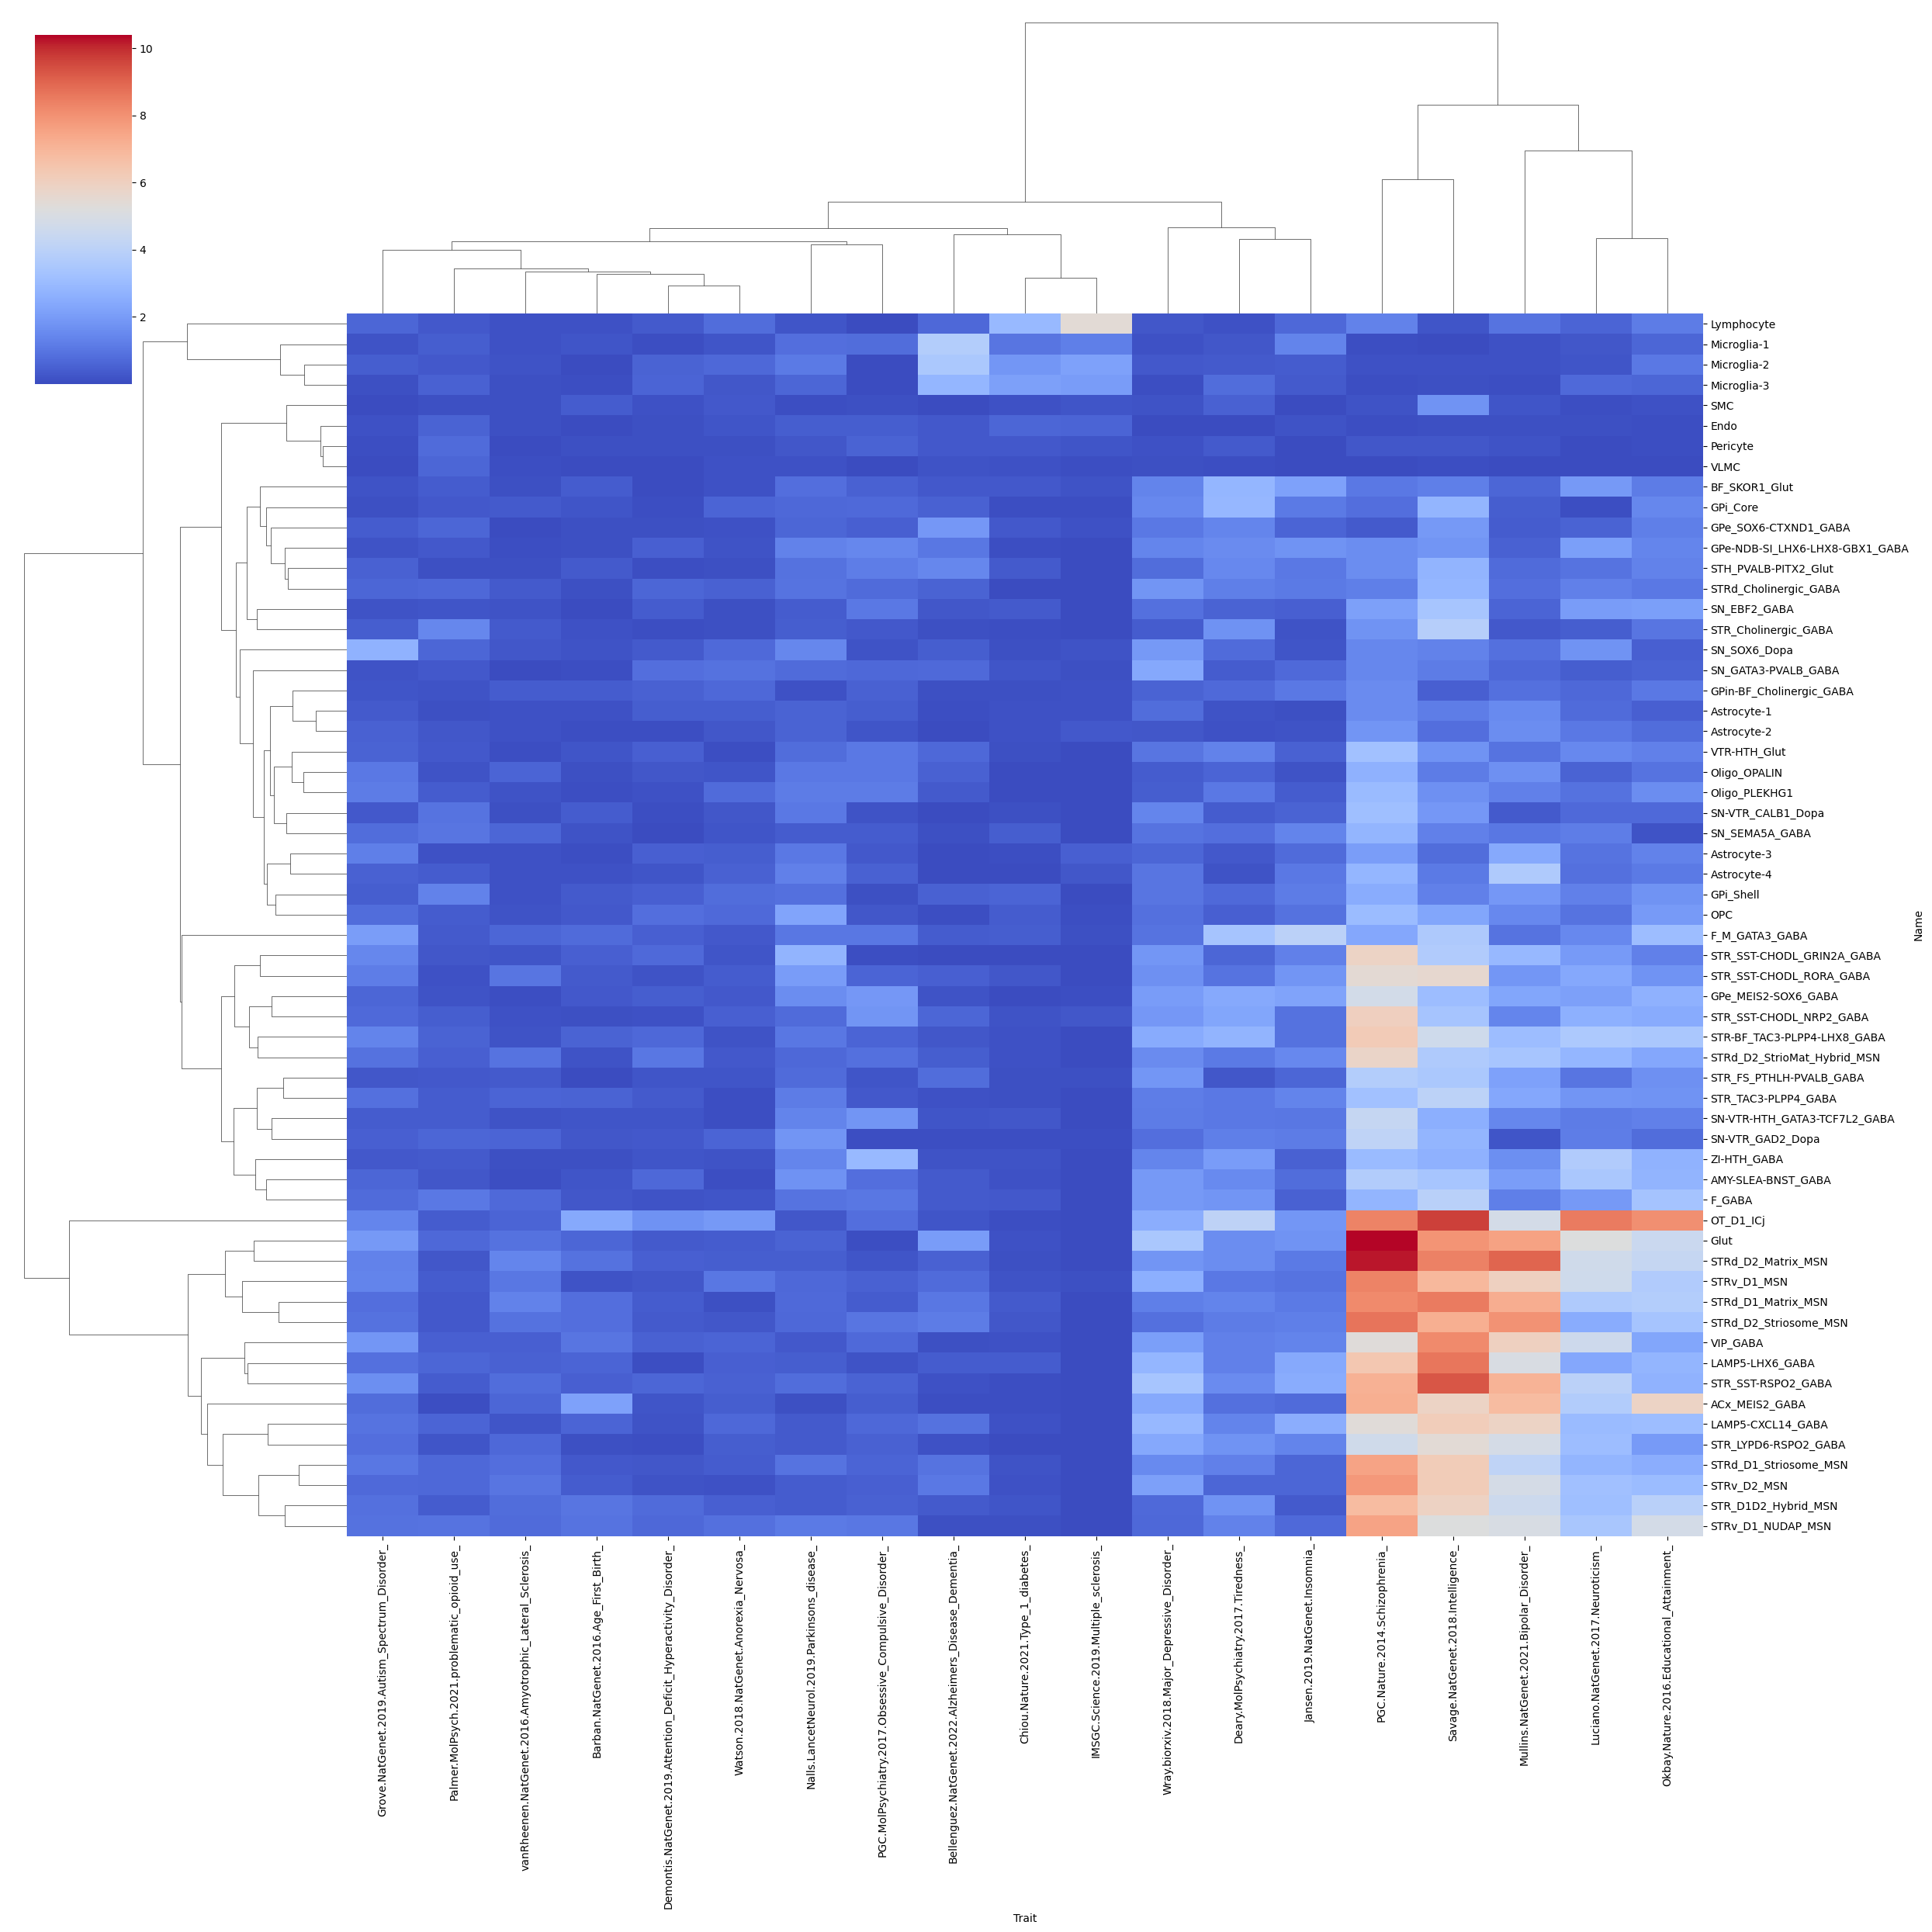

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
g.savefig(f'output/{run_id}_filtered.pdf')

In [13]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [14]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [15]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [16]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Autism Spectrum Disorder', 'Age at First Birth', 'Parkinson's Disease',
       'Obsessive Compulsive Disorder', 'Alzheimers Disease and Dementia',
       'Type 1 Diabetes', 'Multiple Sclerosis', 'Major Depressive Disorder',
       'Tiredness', 'Insomnia', 'Schizophrenia', 'Intelligence',
       'Bipolar Disorder', 'Neuroticism', 'Educational Attainment'],
      dtype='object', name='Trait')

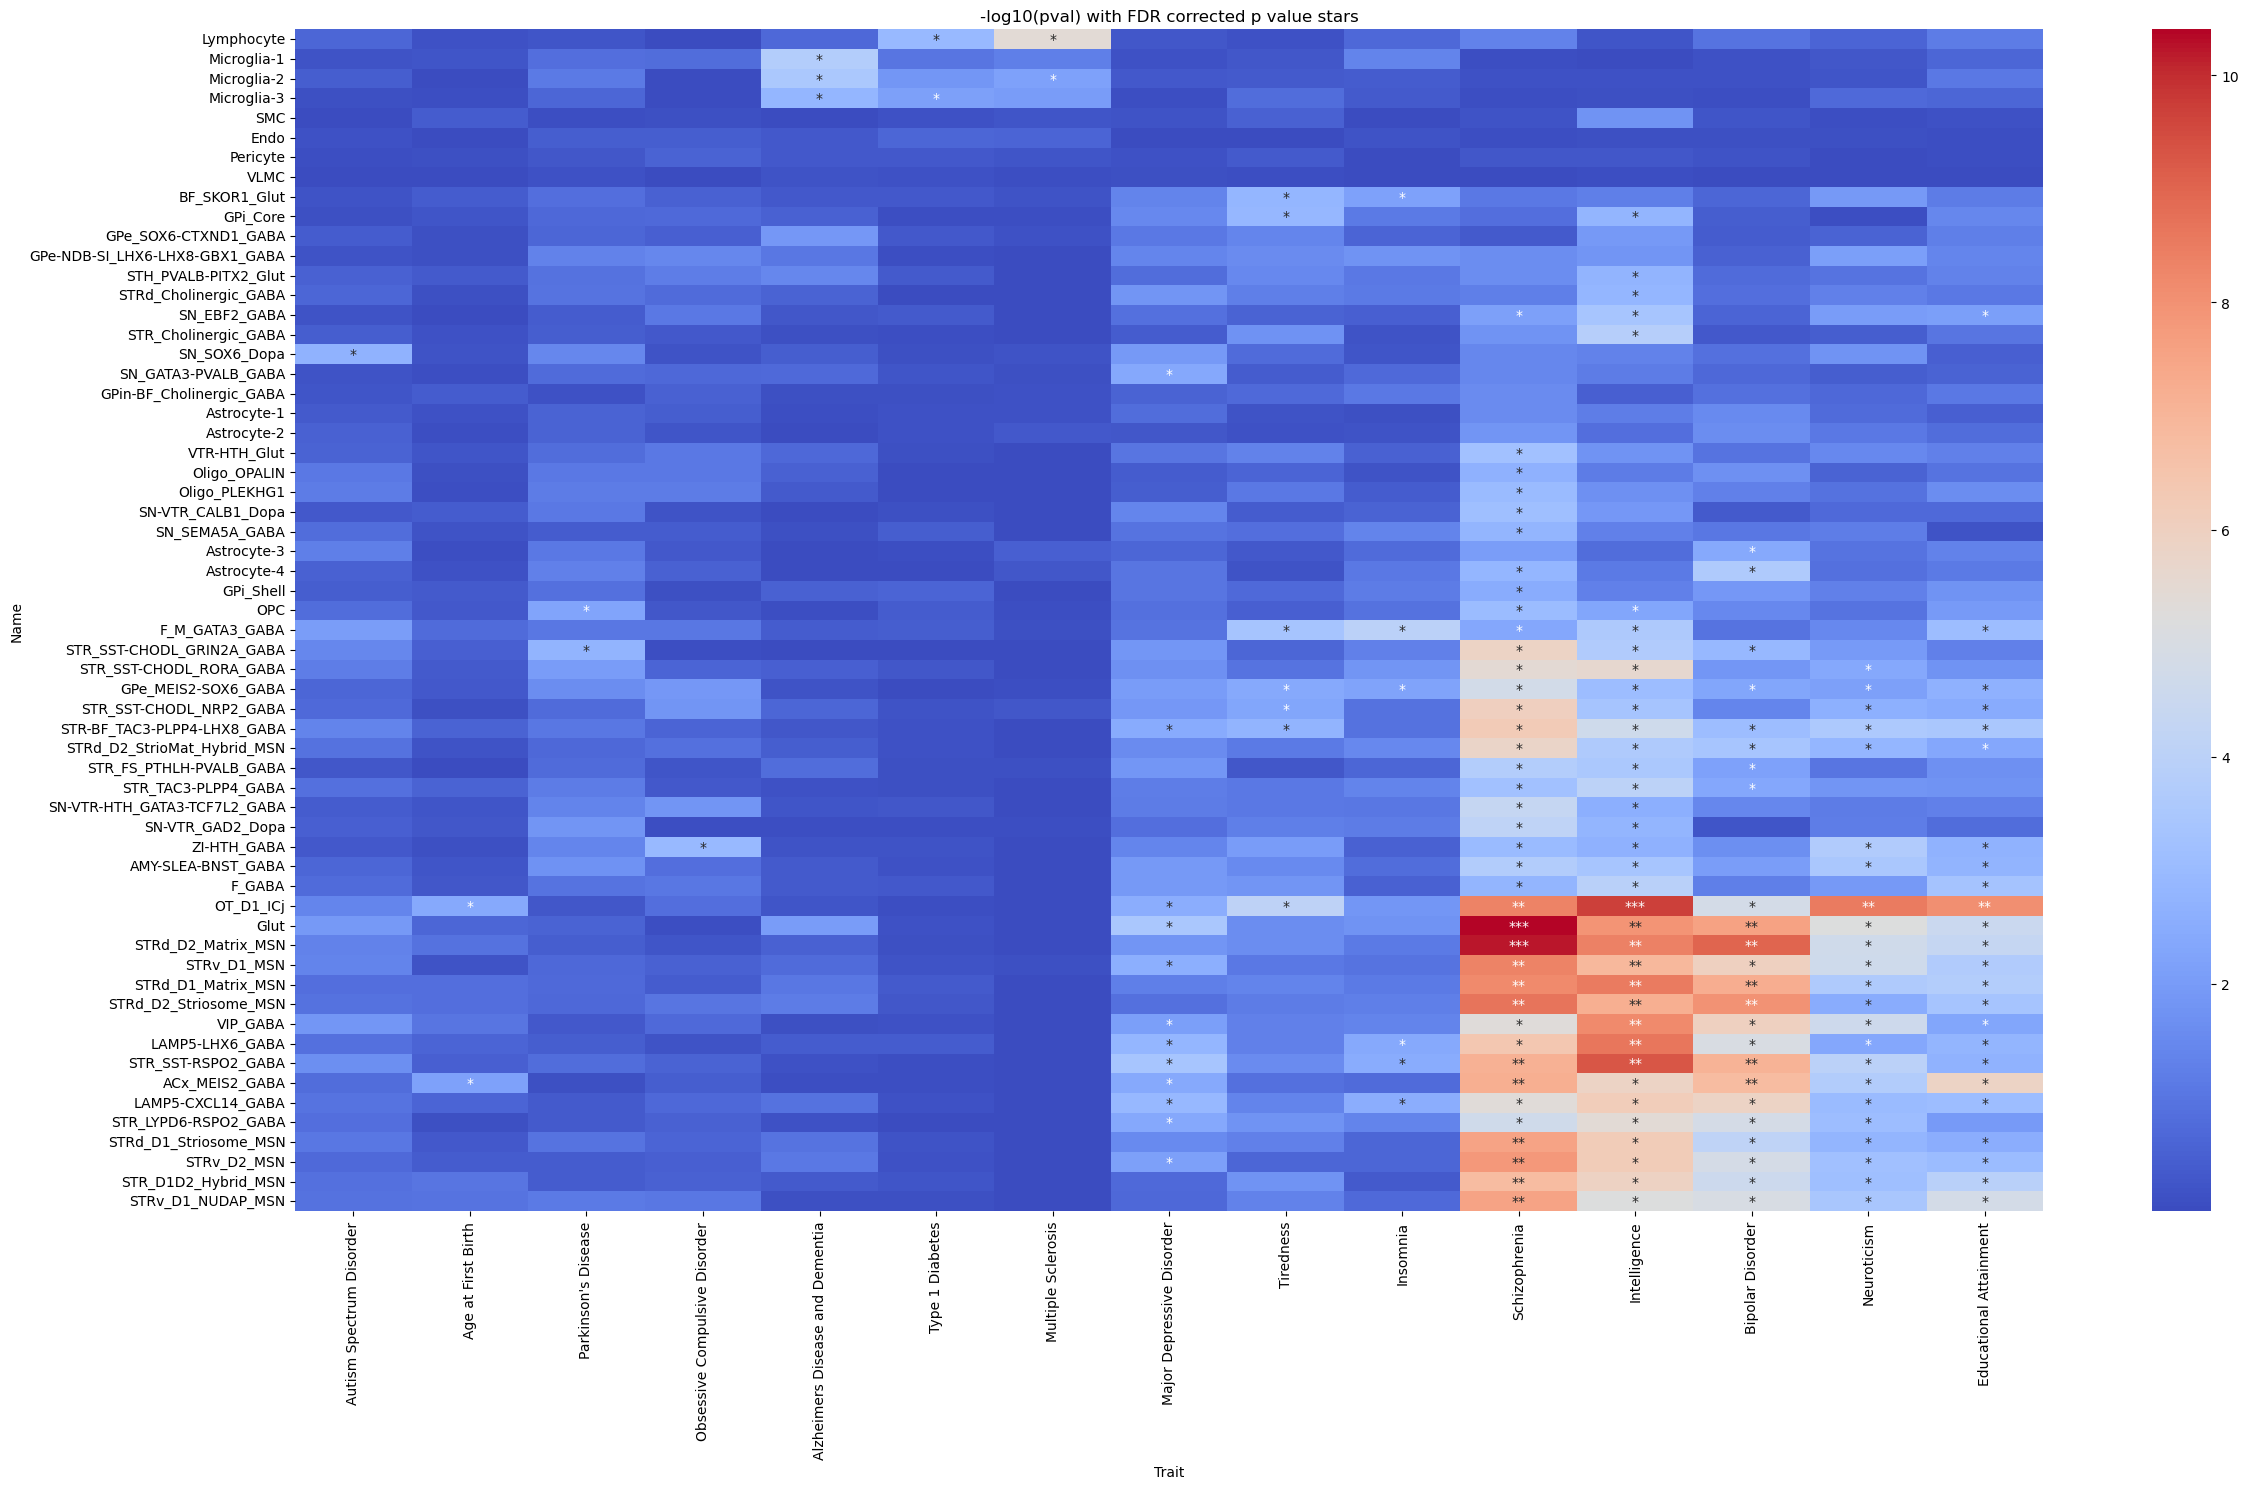

In [ ]:
if len(cols_to_keep) > 0:
    stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

    # Plot heatmap with annotations
    plt.figure(figsize=(25, 15))
    sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with FDR corrected p value stars")
    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
    plt.show()
else:
    # Plot heatmap with annotations
    plt.figure(figsize=(16, 8))
    sns.heatmap(modified_df, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with raw p value")
    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_raw_pval.pdf')
    plt.show()

In [18]:
import os
metadata = pd.read_csv(os.path.expanduser("/anvil/projects/x-mcb130189/Wubin/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols.head()

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron


In [19]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

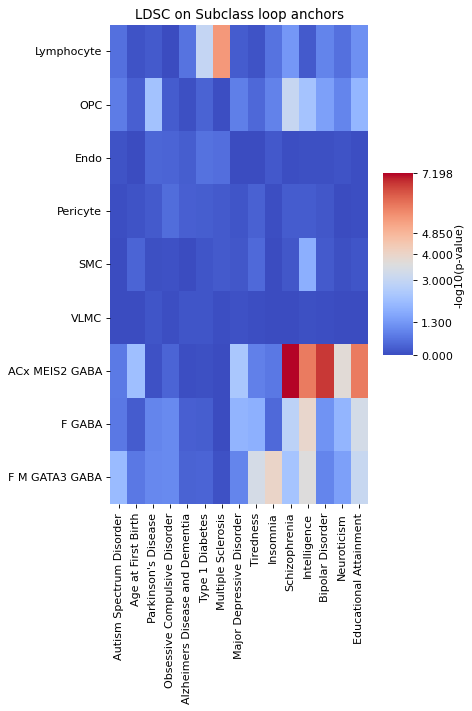

In [ ]:
# Plot heatmap with annotations
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
vmax=modified_df.loc[row_order,cols_to_keep].max().max()

fig, ax = plt.subplots(figsize=(6, 9))
ax=sns.heatmap(modified_df.loc[row_order,cols_to_keep], #annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='coolwarm',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),#vmin=0,vmax=4.85,cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title("LDSC on Subclass loop anchors")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([0,1.3,3,4,4.85,vmax])
plt.tight_layout()
plt.savefig(f'{run_id}_fig.pdf')
# plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/Group_loops.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()